In [1]:
import os
import warnings

import math
import pycbc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

warnings.filterwarnings('ignore')

/home/ashishthomas.mathew/.conda/envs/gengli_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
from modules import statistical_testing

In [3]:
glitches = pd.read_csv('./glitches/O3a_allifo.csv', usecols=['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'])
glitches = glitches[~glitches.duplicated(subset=['GPStime'], keep='first')]
glitches = glitches[glitches["ifo"] == "L1"]

glitches.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label'], dtype='object')

# Testing our normality tests on a combined dataset of glitches and clean data

In this case we have a rather unique challenge where the data at hand is fairly unbalanced, with variations in the number of glitches and clean samples. Hence, for this case I'll take around 1000 samples of each to see how things go.

Our data with glitches has a lot more information to work with such as snr, duration and confidence, which we will not be taking into consideration for now since we want to look at what is common betwen clean and glitches samples.

Additionally our glitches are marked by particular GPS times around which we need to consider a time window to whiten and crop the sample into workable segments for our statistical tests. Our clean data is in the form of time segments of relative "silence" which we will have to process as is and divide into equally sized segments as our glitch data. 

## Loading the data

Let's generate this dataset below

In [4]:
glitch_count_df = glitches["label"].value_counts().rename_axis('Glitch Class').reset_index(name='Count')
glitch_count_df.to_latex("./outputs/glitch_counts.tex", index=False, float_format="%.0f", escape=False)

In [5]:
selection = glitches[(glitches['label'] == 'Tomte')]
samples = statistical_testing.fetch_glitch_data_from_csv(selection, begin=0, n_samples=10)

Time elapsed for q-transform: 0.42 seconds


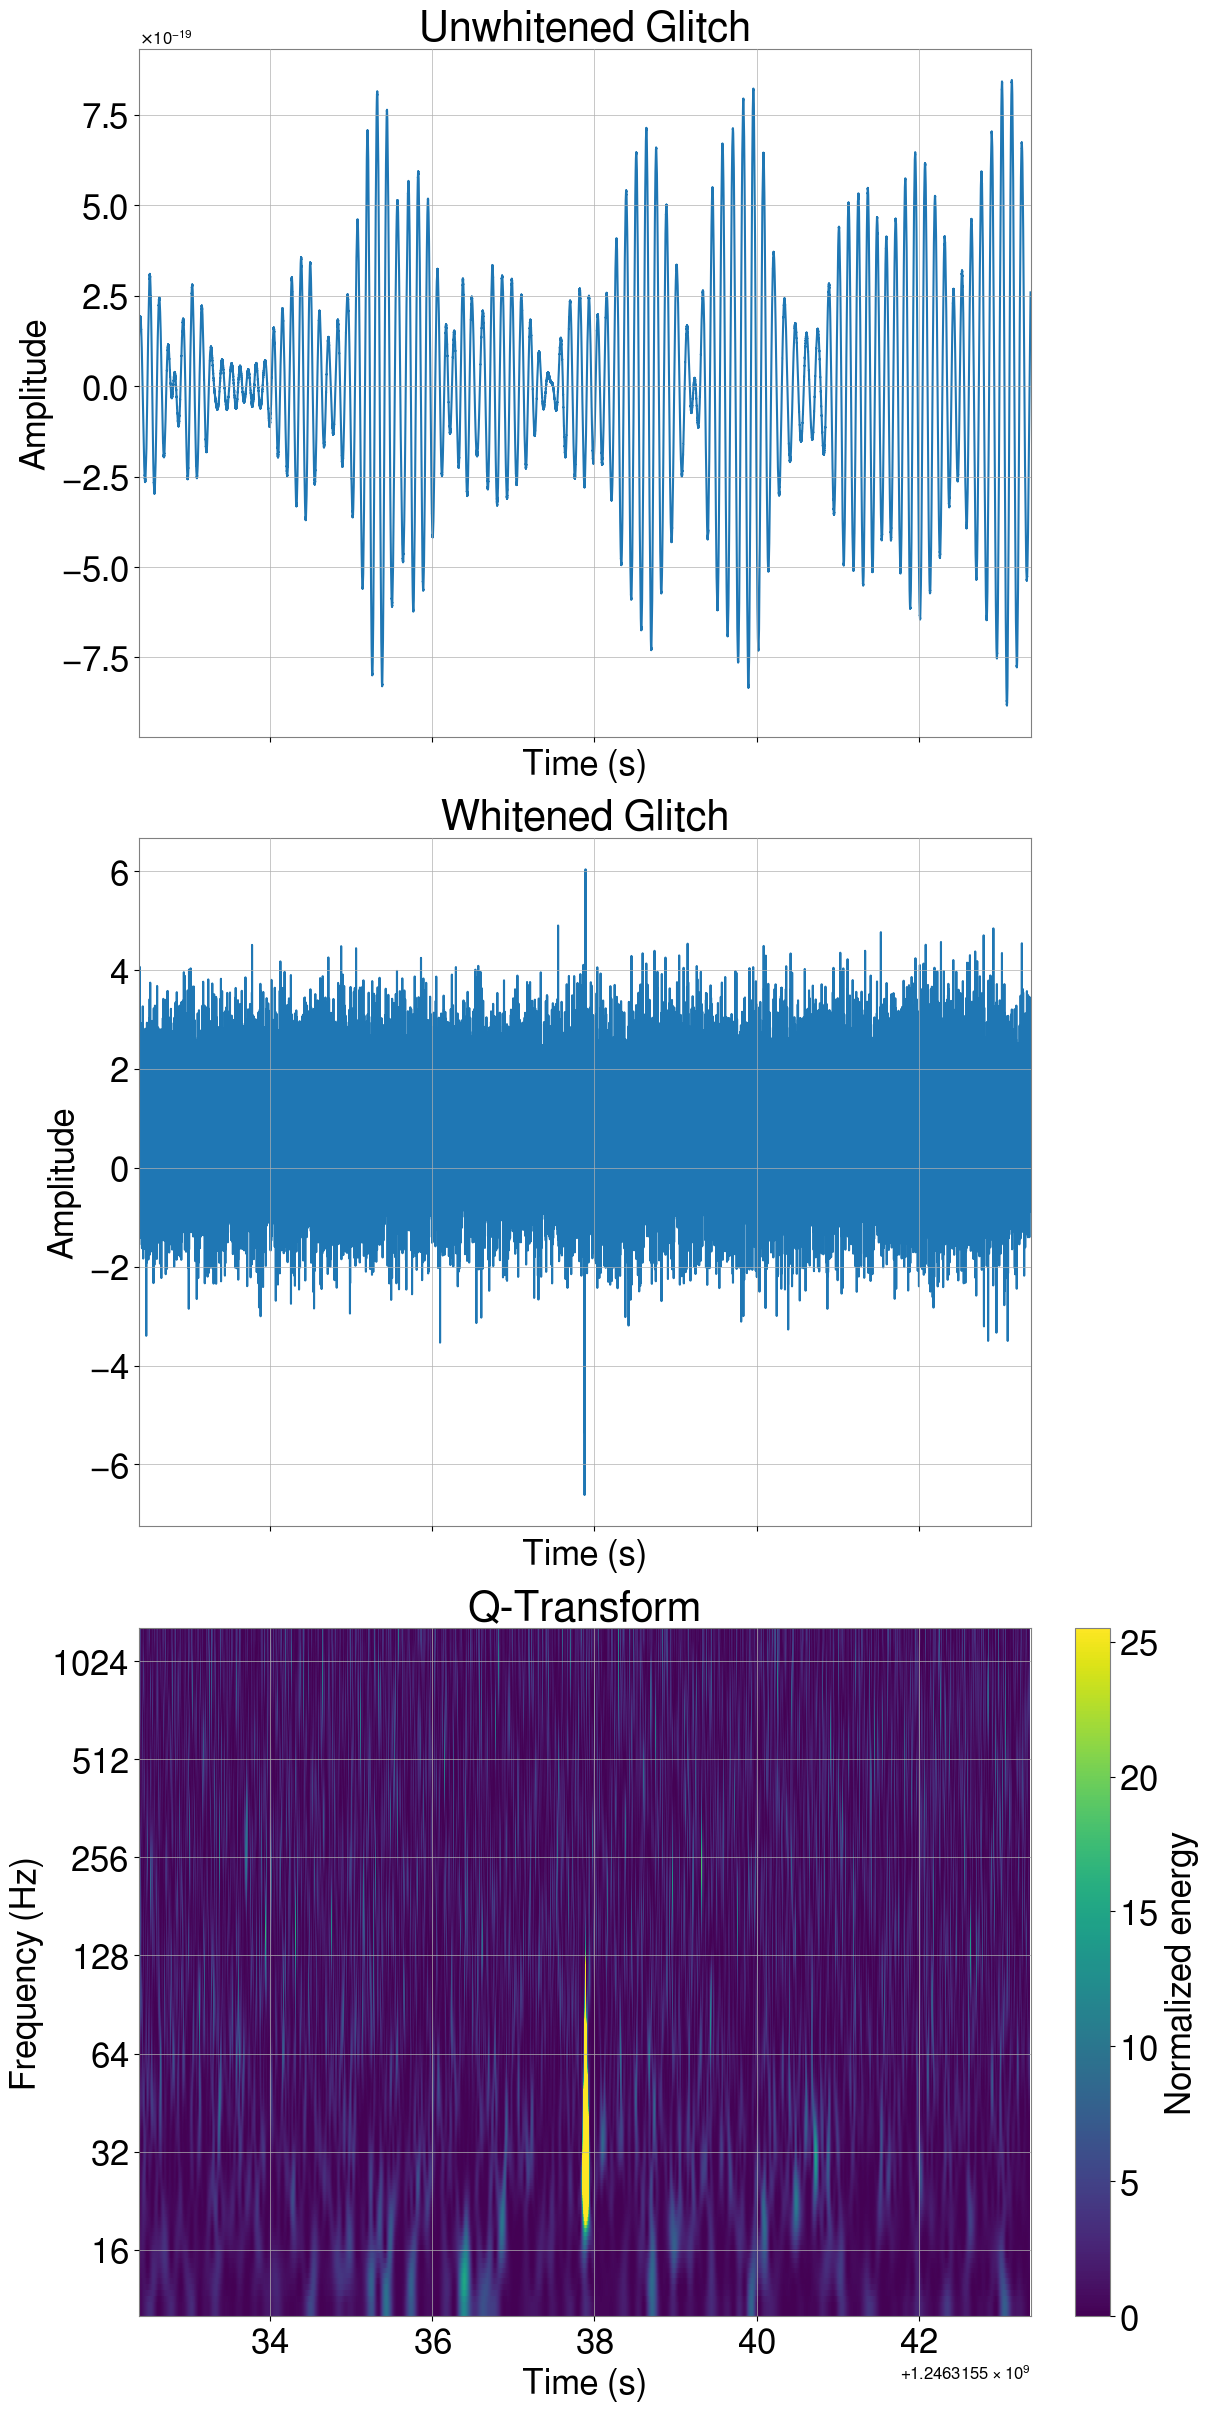

In [6]:
statistical_testing.display_sample_plots(samples.iloc[9], "./outputs/sample_plot.pdf")

In [7]:
samples.columns

Index(['GPStime', 'snr', 'duration', 'confidence', 'ifo', 'label',
       'unwhitened_y', 'whitened_y', 't', 'timeseries_file_location',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'glitch_present'],
      dtype='object')

In [8]:
sample_timeseries = TimeSeries.read(samples["timeseries_file_location"].iloc[0])

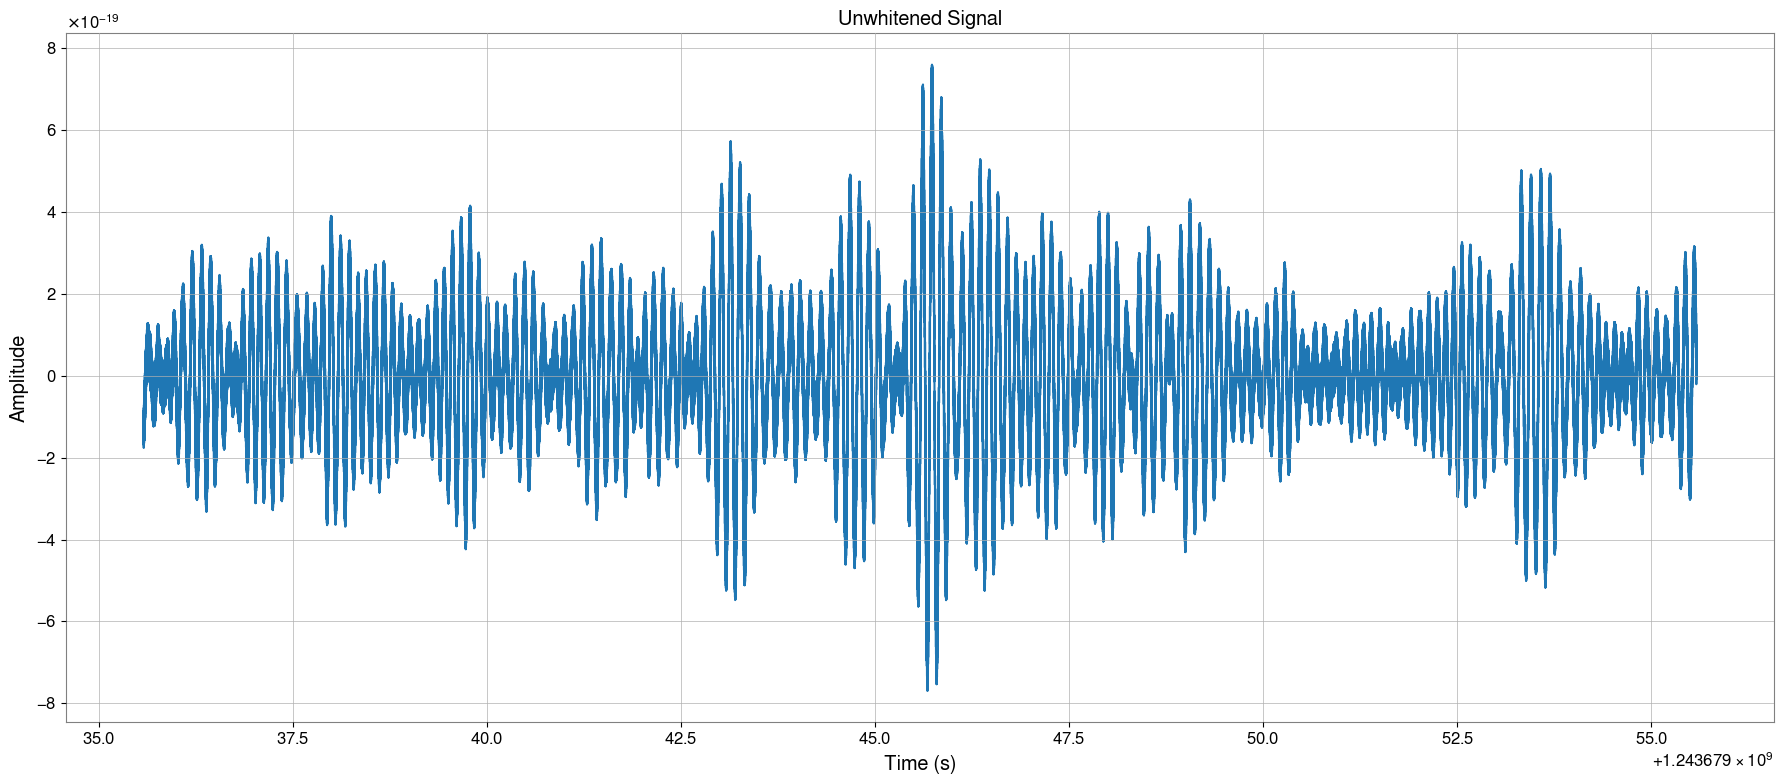

In [9]:
# plot the unwhitened y values for the first chirp
fig = plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries.times, sample_timeseries.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Unwhitened Signal")
plt.tight_layout()
plt.savefig("./outputs/unwhitened_signal.pdf", dpi=100)

In [10]:
#whiten the timeseries
sample_timeseries_whitened = sample_timeseries.whiten(4,2)

In [11]:
sample_timeseries_whitened = sample_timeseries_whitened[int(4096*4):-int(4096*4)]

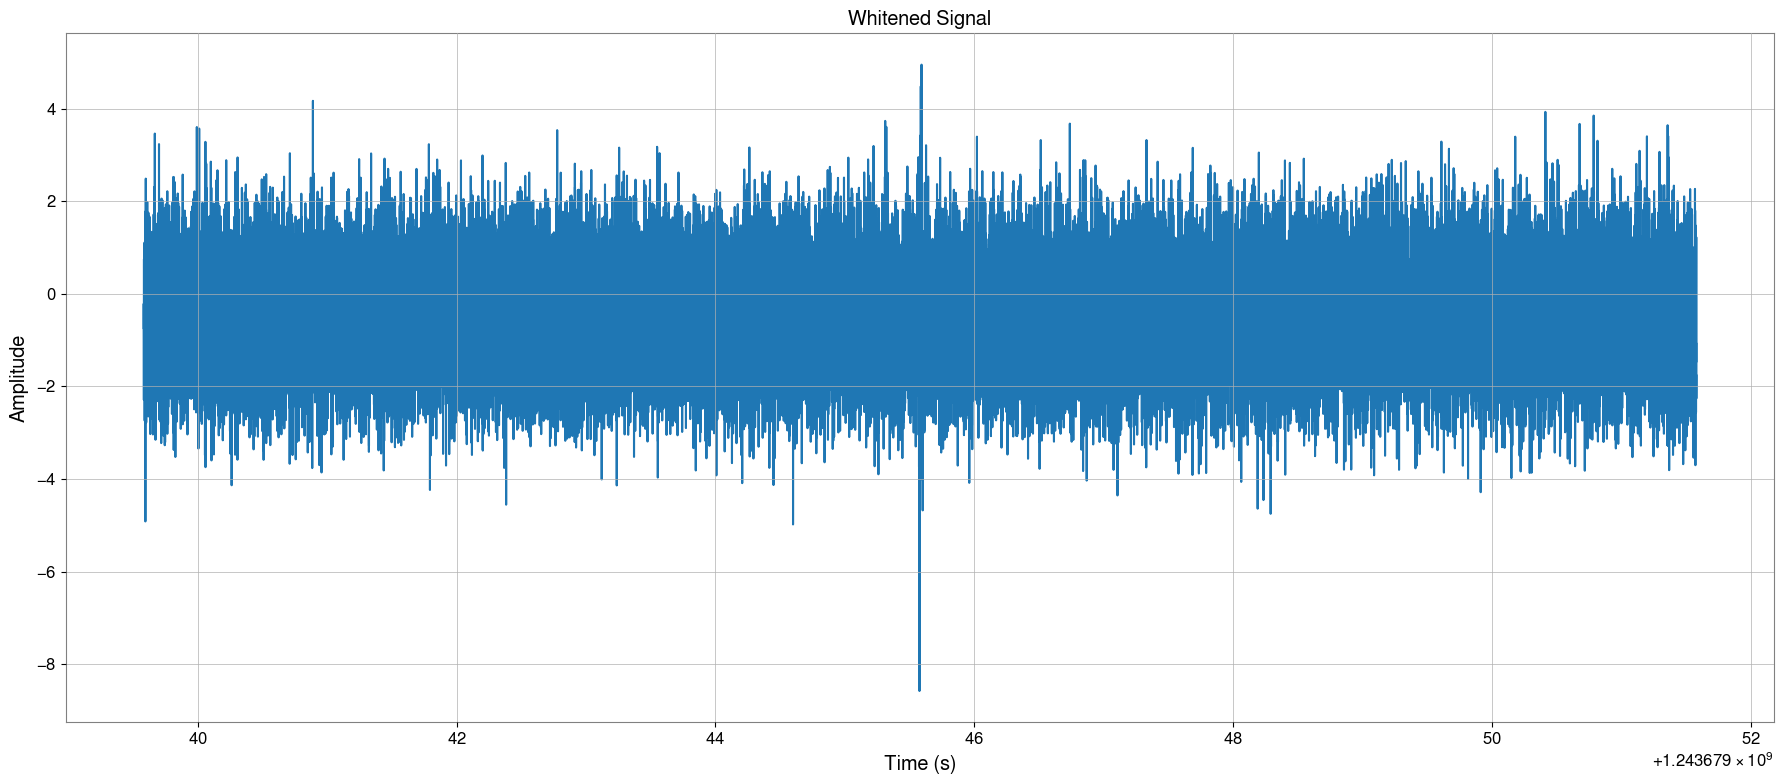

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(sample_timeseries_whitened.times, sample_timeseries_whitened.value)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Whitened Signal")
plt.tight_layout()
plt.savefig("./outputs/whitened_signal.pdf", dpi=100)

In [13]:
sample_asd = sample_timeseries.asd(4, 2)

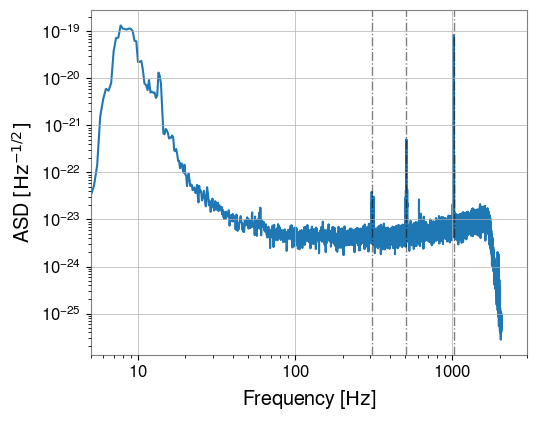

In [14]:
plot = sample_asd.plot()
ax = plot.gca()
ax.set_xlim(5, 3000)
# ax.set_ylim(5e-26, 1e-21)

#plot dotted lines at 512 Hz and 1024Hz
ax.axvline(x=310, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=510, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.axvline(x=1020, color='black', linestyle='-.', linewidth=1, alpha=0.5)
ax.set_ylabel("ASD $[\mathrm{Hz}^{-1/2}]$")

plot.savefig("./outputs/unwhitened_asd.pdf", dpi=100)

In [15]:
labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip',
       'Blip_Low_Frequency', 'Chirp', 'Extremely_Loud',
       'Fast_Scattering', 'Helix', 'Koi_Fish',
       'Light_Modulation', 'Low_Frequency_Burst',
       'Low_Frequency_Lines', 'Paired_Doves',
       'Power_Line', 'Repeating_Blips', 'Scattered_Light',
       'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle', 'clean_signal']

columns = [
    'label', "shapiro_TP", "shapiro_FN",
    "shapiro_FP", "shapiro_TN", "shapiro_accuracy", "shapiro_recall", "shapiro_fpr",
    "shapiro_precision", "shapiro_f1_score", "KS_TP",
    "KS_FN", "KS_FP", "KS_TN",
    "KS_accuracy", "KS_recall", "KS_fpr", "KS_precision",
    "KS_f1_score", "AD_TP", "AD_FN", "AD_FP", "AD_TN",
    "AD_accuracy", "AD_recall", "AD_fpr", "AD_precision", "AD_f1_score"]


def generate_glitchwise_confusion_matrices(df):

    scaler = StandardScaler()

    confusion_matrix_df = pd.DataFrame(columns=columns)
    for label in labels:
        temp_df = df[df['label'] == label]

        # print(f"Loading {label} data...")

        # temp_df = statistical_testing.fetch_glitch_data_from_csv(temp_df, tw=10, bandpass=bandpass, low_freq=low_feq, high_freq=high_freq)
        # temp_df.dropna(inplace=True)

        # print(f"Generating confusion matrix for {label}...")
        shapiro_cm = statistical_testing.generate_confusion_matrix(temp_df)
        ks_cm = statistical_testing.generate_confusion_matrix(temp_df, "KS")
        ad_cm = statistical_testing.generate_confusion_matrix(temp_df, "Anderson")

        shapiro_metrics = list(statistical_testing.generate_evaluation_metrics(shapiro_cm))
        ks_metrics = list(statistical_testing.generate_evaluation_metrics(ks_cm))
        ad_metrics = list(statistical_testing.generate_evaluation_metrics(ad_cm))

        shapiro_cm = shapiro_cm.flatten()
        ks_cm = ks_cm.flatten()
        ad_cm = ad_cm.flatten()

        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[label] + shapiro_cm.tolist() + shapiro_metrics + ks_cm.tolist() + ks_metrics + ad_cm.tolist() + ad_metrics], columns=columns)], ignore_index=True)

    return confusion_matrix_df
    

In [16]:
def generate_testwise_confusion_matrix(df):

    confusion_matrix_df = pd.DataFrame(columns=["Test","TP","FN","FP","TN","Accuracy","Recall(TPR/Sensitivity)", "FPR","Precision","F1 Score"])
    for test in ["Shapiro", "KS", "Anderson"]:
        # print(f"Generating confusion matrix for {test}...")
        cm = statistical_testing.generate_confusion_matrix(df, test)
        metrics = list(statistical_testing.generate_evaluation_metrics(cm))
        cm = cm.flatten()
        confusion_matrix_df = pd.concat([confusion_matrix_df, pd.DataFrame([[test] + cm.tolist() + metrics], columns=confusion_matrix_df.columns)], ignore_index=True)
    
    return confusion_matrix_df

In [17]:
# Loading up the clean segments
clean_gpstimes = pd.read_csv("./clean_segments/pre_clean_segments_O3a_L1.csv", usecols=['start_time', 'end_time', 'p_values'])

# Loading up the glitch data times and randomly sampling 51 glitches from each label
sample_glitches = pd.read_csv('./glitches/DQ_glitches_O3a.csv', usecols=['GPStime', 'ifo', 'label'])
# Excluide 'no_glitch' label
sample_glitches = sample_glitches[sample_glitches['label'] != 'No_Glitch']
sample_glitches = sample_glitches[~sample_glitches.duplicated(subset=['GPStime'], keep='first')]


if not os.path.isfile("./glitches/random_samples.csv"):
    sample_glitches_df = sample_glitches[sample_glitches['ifo'] == 'L1'].groupby('label').apply(lambda x: x.sample(n=min(len(x),101))).reset_index(drop=True)
    sample_glitches_df.to_csv("./glitches/random_samples.csv", index=False)
else:
    sample_glitches_df = pd.read_csv("./glitches/random_samples.csv", index_col=False)

In [18]:
def create_combined_glitch_clean_df(clean_gpstimes, sample_glitches_df, n_samples=1000, bandpass=False, low_freq=10, high_freq=250):
    clean_samples_df = statistical_testing.fetch_clean_segment_samples(clean_gpstimes, n_samples=n_samples, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)
    sample_glitches_df = statistical_testing.fetch_glitch_data_from_csv(sample_glitches_df, tw=10, bandpass=bandpass, low_freq=low_freq, high_freq=high_freq)

    print(clean_samples_df.columns)
    print(sample_glitches_df.columns)
    # , 'shapiro_prediction', 'ks_prediction', 'ad_prediction'
    sample_glitches_df = sample_glitches_df[['whitened_y', 'unwhitened_y', 't', "timeseries_file_location", 'shapiro_statistic', 'shapiro_pvalue',
	    'ks_statistic', 'ks_pvalue', 'ad_statistic',
	    'ad_critical_values', 'ad_significance_level', 'kurtosis', 'skew',
	    'ifo', 'label', 'glitch_present']]

    sample_glitches_df = sample_glitches_df.dropna()
    clean_samples_df = clean_samples_df.dropna()

    # Combining the clean and glitch data
    combined_df = pd.concat([clean_samples_df, sample_glitches_df], ignore_index=True)
    
    return combined_df

In [19]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


In [20]:
combined_df[combined_df.isna().any(axis=1)].head()

,whitened_y,t,timeseries_file_location,unwhitened_y,shapiro_statistic,shapiro_pvalue,ks_statistic,ks_pvalue,ad_statistic,ad_critical_values,ad_significance_level,kurtosis,skew,ifo,label,glitch_present


In [21]:
len(combined_df)

3597

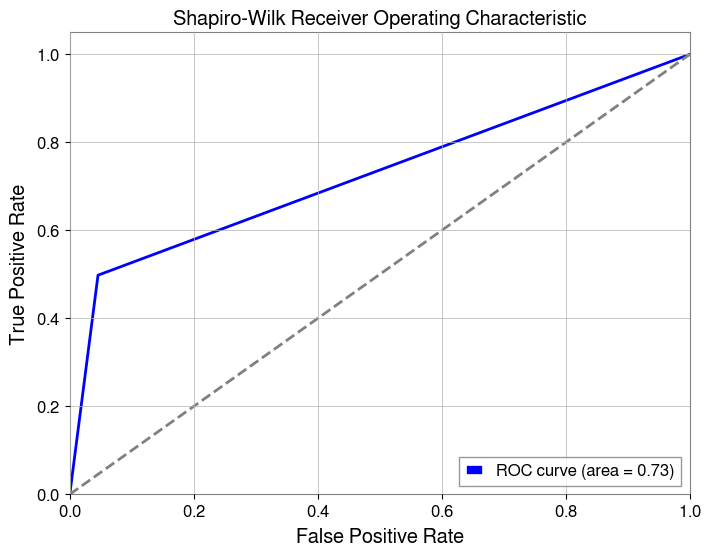

In [22]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])

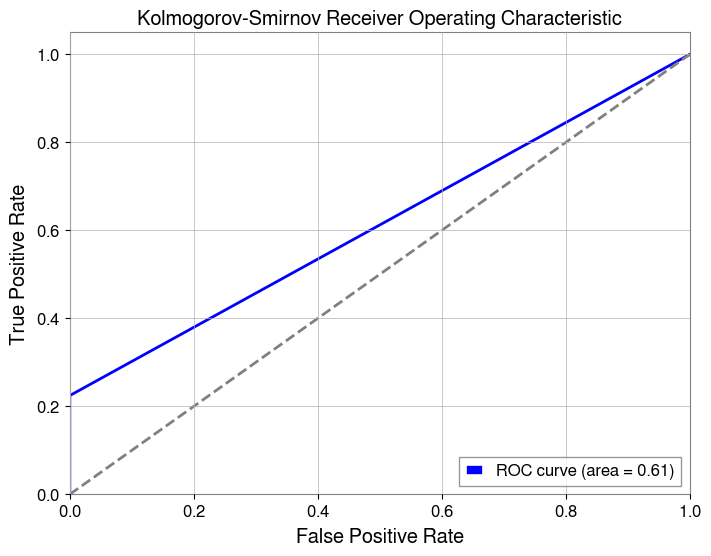

In [23]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")

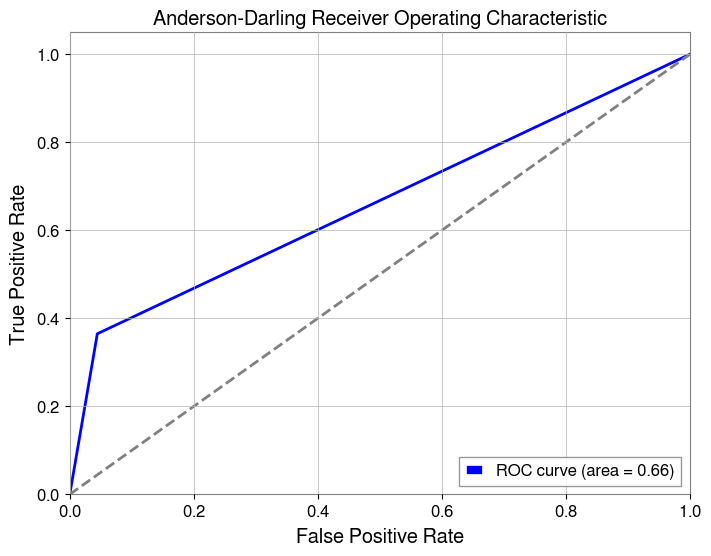

In [24]:
statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

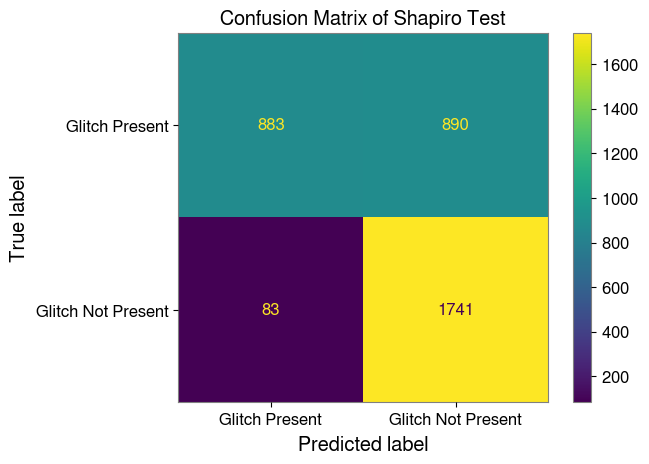

In [25]:
statistical_testing.display_confusion_matrix(combined_df)

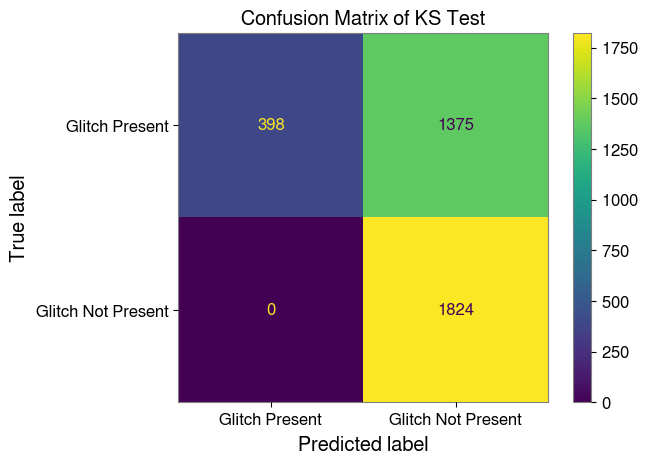

In [26]:
statistical_testing.display_confusion_matrix(combined_df, "KS")

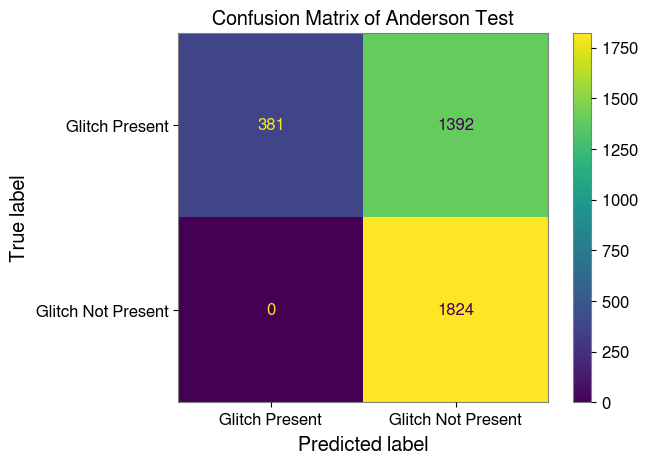

In [27]:
statistical_testing.display_confusion_matrix(combined_df, "Anderson")

I will now perform the same tests using a band pass filter

In [28]:
bp_combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=10, high_freq=1000)

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


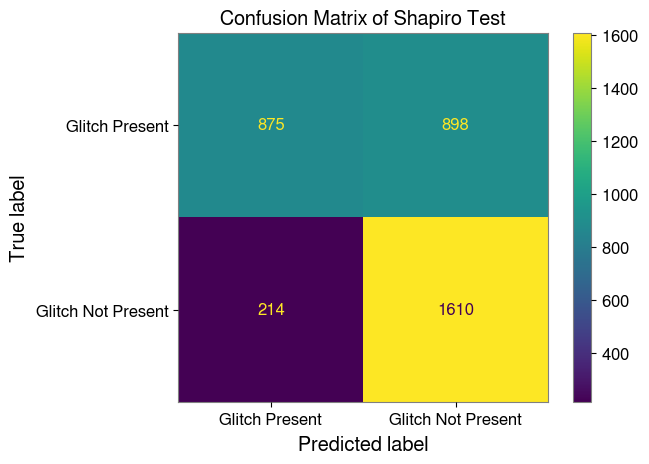

In [29]:
statistical_testing.display_confusion_matrix(bp_combined_df)

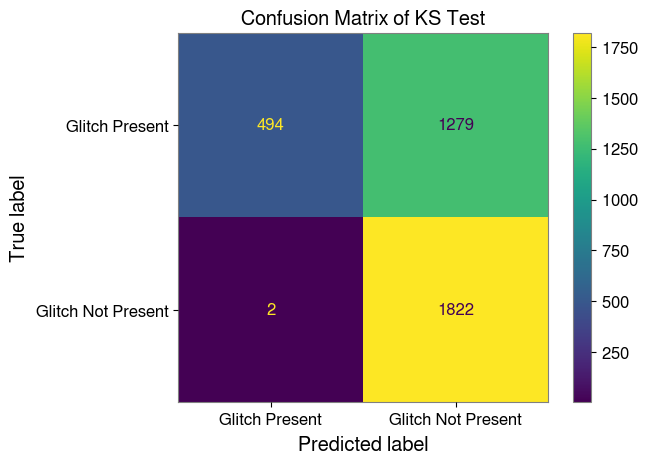

In [30]:
statistical_testing.display_confusion_matrix(bp_combined_df, "KS")

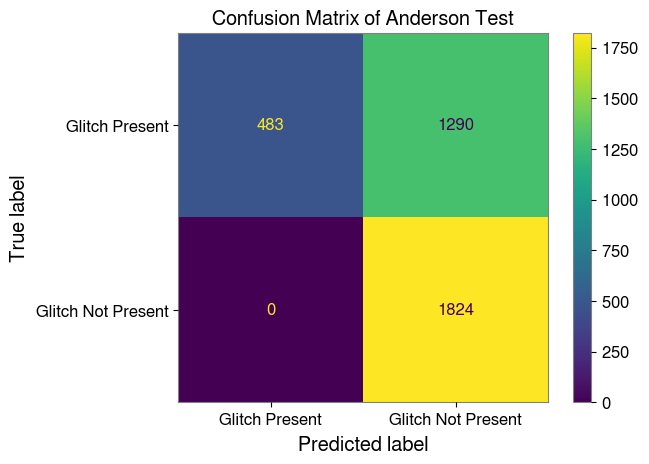

In [31]:
statistical_testing.display_confusion_matrix(bp_combined_df, "Anderson")

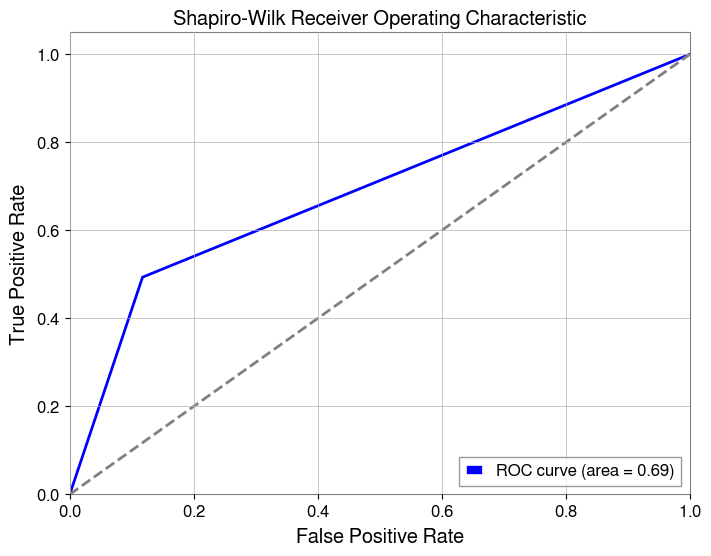

In [32]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['shapiro_pvalue'])

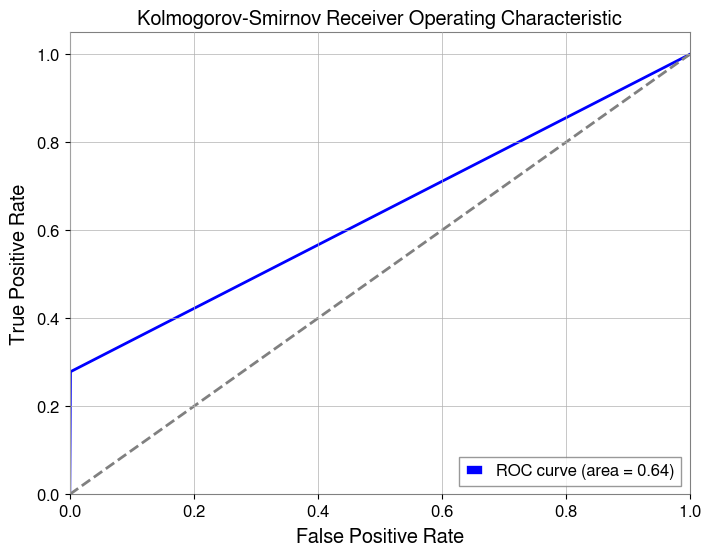

In [33]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df['ks_pvalue'], "KS")

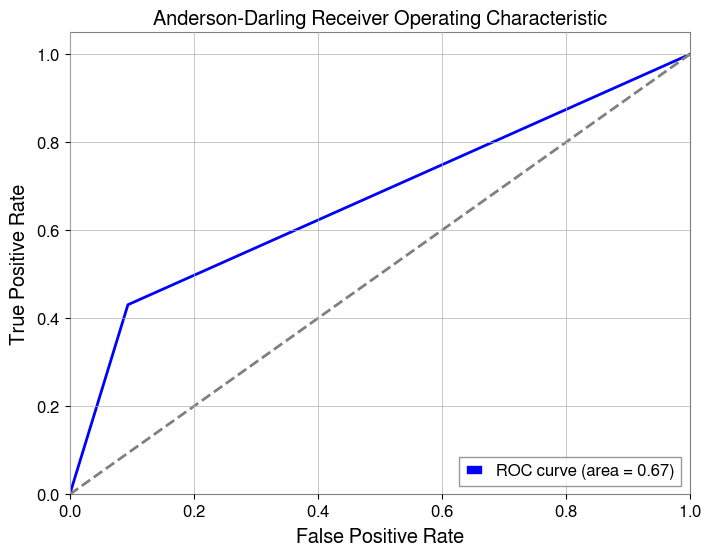

In [34]:
statistical_testing.display_auc_roc(bp_combined_df['glitch_present'], bp_combined_df[['ad_statistic','ad_critical_values']], "Anderson")

In [35]:
generate_glitchwise_confusion_matrices(combined_df)

,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,51,50,0,0,0.50495,0.50495,0,1.00000,0.67105,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
2,Air_Compressor,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
3,Blip,93,7,0,0,0.93000,0.93000,0,1.00000,0.96373,15,85,0,0,0.15000,0.15000,0,1.00000,0.26087,12,88,0,0,0.12000,0.12000,0,1.00000,0.21429
4,Blip_Low_Frequency,18,83,0,0,0.17822,0.17822,0,1.00000,0.30252,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
5,Chirp,0,6,0,0,0.00000,0.00000,0,0.00000,0.00000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,14,7,0,0,0.66667,0.66667,0,1.00000,0.80000,12,9,0,0,0.57143,0.57143,0,1.00000,0.72727
9,Koi_Fish,100,1,0,0,0.99010,0.99010,0,1.00000,0.99502,93,8,0,0,0.92079,0.92079,0,1.00000,0.95876,93,8,0,0,0.92079,0.92079,0,1.00000,0.95876


In [36]:
generate_glitchwise_confusion_matrices(bp_combined_df)

,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
2,Air_Compressor,11,90,0,0,0.10891,0.10891,0,1.00000,0.19643,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
3,Blip,99,1,0,0,0.99000,0.99000,0,1.00000,0.99497,29,71,0,0,0.29000,0.29000,0,1.00000,0.44961,30,70,0,0,0.30000,0.30000,0,1.00000,0.46154
4,Blip_Low_Frequency,24,77,0,0,0.23762,0.23762,0,1.00000,0.38400,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
5,Chirp,2,4,0,0,0.33333,0.33333,0,1.00000,0.50000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000
9,Koi_Fish,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,97,4,0,0,0.96040,0.96040,0,1.00000,0.97980,97,4,0,0,0.96040,0.96040,0,1.00000,0.97980


In [37]:
generate_testwise_confusion_matrix(combined_df)

,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,883,890,83,1741,0.72950,0.49803,0.04550,0.91408,0.64476
1,KS,398,1375,0,1824,0.61774,0.22448,0.00000,1.00000,0.36665
2,Anderson,381,1392,0,1824,0.61301,0.21489,0.00000,1.00000,0.35376


In [38]:
generate_testwise_confusion_matrix(bp_combined_df)

,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,875,898,214,1610,0.69085,0.49351,0.11732,0.80349,0.61146
1,KS,494,1279,2,1822,0.64387,0.27862,0.00110,0.99597,0.43543
2,Anderson,483,1290,0,1824,0.64137,0.27242,0.00000,1.00000,0.42819


In [39]:
frequency_ranges=[[10, 100], [10, 250], [10, 500], [10, 1000], [250,1000], [500,1000]]

combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_testwise_confusion_matrix(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_testwise_confusion_matrix(combined_df))
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['shapiro_pvalue'])
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df['ks_pvalue'], "KS")
    # statistical_testing.display_auc_roc(combined_df['glitch_present'], combined_df[['ad_statistic','ad_critical_values']], "Anderson")

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,883,890,83,1741,0.72950,0.49803,0.04550,0.91408,0.64476
1,KS,398,1375,0,1824,0.61774,0.22448,0.00000,1.00000,0.36665
2,Anderson,381,1392,0,1824,0.61301,0.21489,0.00000,1.00000,0.35376


Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,1772,1,1818,6,0.49430,0.99944,0.99671,0.49359,0.66082
1,KS,1480,293,907,917,0.66639,0.83474,0.49726,0.62003,0.71154
2,Anderson,1213,560,294,1530,0.76258,0.68415,0.16118,0.80491,0.73963


Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,1632,141,1550,274,0.52989,0.92047,0.84978,0.51288,0.65873
1,KS,898,875,195,1629,0.70253,0.50649,0.10691,0.82159,0.62666
2,Anderson,743,1030,15,1809,0.70948,0.41906,0.00822,0.98021,0.58712


Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,1167,606,778,1046,0.61523,0.65821,0.42654,0.60000,0.62776
1,KS,604,1169,29,1795,0.66694,0.34067,0.01590,0.95419,0.50208
2,Anderson,564,1209,0,1824,0.66389,0.31810,0.00000,1.00000,0.48267


Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,875,898,214,1610,0.69085,0.49351,0.11732,0.80349,0.61146
1,KS,494,1279,2,1822,0.64387,0.27862,0.00110,0.99597,0.43543
2,Anderson,483,1290,0,1824,0.64137,0.27242,0.00000,1.00000,0.42819


Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,631,1142,120,1704,0.64915,0.35589,0.06579,0.84021,0.50000
1,KS,295,1478,0,1824,0.58910,0.16638,0.00000,1.00000,0.28530
2,Anderson,288,1485,0,1824,0.58716,0.16244,0.00000,1.00000,0.27948


Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,Test,TP,FN,FP,TN,Accuracy,Recall(TPR/Sensitivity),FPR,Precision,F1 Score
0,Shapiro,591,1182,85,1739,0.64776,0.33333,0.04660,0.87426,0.48265
1,KS,294,1479,0,1824,0.58882,0.16582,0.00000,1.00000,0.28447
2,Anderson,273,1500,0,1824,0.58299,0.15398,0.00000,1.00000,0.26686


In [40]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000)
display(generate_glitchwise_confusion_matrices(combined_df))
for low_freq, high_freq in frequency_ranges:
    print(f"Low Frequency: {low_freq}, High Frequency: {high_freq}")
    combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=low_freq, high_freq=high_freq)
    display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,51,50,0,0,0.50495,0.50495,0,1.00000,0.67105,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
2,Air_Compressor,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
3,Blip,93,7,0,0,0.93000,0.93000,0,1.00000,0.96373,15,85,0,0,0.15000,0.15000,0,1.00000,0.26087,12,88,0,0,0.12000,0.12000,0,1.00000,0.21429
4,Blip_Low_Frequency,18,83,0,0,0.17822,0.17822,0,1.00000,0.30252,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
5,Chirp,0,6,0,0,0.00000,0.00000,0,0.00000,0.00000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,14,7,0,0,0.66667,0.66667,0,1.00000,0.80000,12,9,0,0,0.57143,0.57143,0,1.00000,0.72727
9,Koi_Fish,100,1,0,0,0.99010,0.99010,0,1.00000,0.99502,93,8,0,0,0.92079,0.92079,0,1.00000,0.95876,93,8,0,0,0.92079,0.92079,0,1.00000,0.95876


Low Frequency: 10, High Frequency: 100
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,6,0,0,0,1.00000,1.00000,0,1.00000,1.00000,5,1,0,0,0.83333,0.83333,0,1.00000,0.90909,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571
1,1400Ripples,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,57,44,0,0,0.56436,0.56436,0,1.00000,0.72152,11,90,0,0,0.10891,0.10891,0,1.00000,0.19643
2,Air_Compressor,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,80,21,0,0,0.79208,0.79208,0,1.00000,0.88398,58,43,0,0,0.57426,0.57426,0,1.00000,0.72956
3,Blip,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,77,23,0,0,0.77000,0.77000,0,1.00000,0.87006,66,34,0,0,0.66000,0.66000,0,1.00000,0.79518
4,Blip_Low_Frequency,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,87,14,0,0,0.86139,0.86139,0,1.00000,0.92553,65,36,0,0,0.64356,0.64356,0,1.00000,0.78313
5,Chirp,6,0,0,0,1.00000,1.00000,0,1.00000,1.00000,3,3,0,0,0.50000,0.50000,0,1.00000,0.66667,3,3,0,0,0.50000,0.50000,0,1.00000,0.66667
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,86,15,0,0,0.85149,0.85149,0,1.00000,0.91979,54,47,0,0,0.53465,0.53465,0,1.00000,0.69677
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000
9,Koi_Fish,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000


Low Frequency: 10, High Frequency: 250
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,6,0,0,0,1.00000,1.00000,0,1.00000,1.00000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,76,25,0,0,0.75248,0.75248,0,1.00000,0.85876,8,93,0,0,0.07921,0.07921,0,1.00000,0.14679,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769
2,Air_Compressor,85,16,0,0,0.84158,0.84158,0,1.00000,0.91398,20,81,0,0,0.19802,0.19802,0,1.00000,0.33058,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215
3,Blip,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,65,35,0,0,0.65000,0.65000,0,1.00000,0.78788,58,42,0,0,0.58000,0.58000,0,1.00000,0.73418
4,Blip_Low_Frequency,99,2,0,0,0.98020,0.98020,0,1.00000,0.99000,33,68,0,0,0.32673,0.32673,0,1.00000,0.49254,20,81,0,0,0.19802,0.19802,0,1.00000,0.33058
5,Chirp,6,0,0,0,1.00000,1.00000,0,1.00000,1.00000,2,4,0,0,0.33333,0.33333,0,1.00000,0.50000,2,4,0,0,0.33333,0.33333,0,1.00000,0.50000
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,84,17,0,0,0.83168,0.83168,0,1.00000,0.90811,17,84,0,0,0.16832,0.16832,0,1.00000,0.28814,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000
9,Koi_Fish,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000


Low Frequency: 10, High Frequency: 500
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,2,4,0,0,0.33333,0.33333,0,1.00000,0.50000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,34,67,0,0,0.33663,0.33663,0,1.00000,0.50370,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
2,Air_Compressor,41,60,0,0,0.40594,0.40594,0,1.00000,0.57746,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
3,Blip,99,1,0,0,0.99000,0.99000,0,1.00000,0.99497,42,58,0,0,0.42000,0.42000,0,1.00000,0.59155,41,59,0,0,0.41000,0.41000,0,1.00000,0.58156
4,Blip_Low_Frequency,57,44,0,0,0.56436,0.56436,0,1.00000,0.72152,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434
5,Chirp,4,2,0,0,0.66667,0.66667,0,1.00000,0.80000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,35,66,0,0,0.34653,0.34653,0,1.00000,0.51471,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000
9,Koi_Fish,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,1,0,0,0.99010,0.99010,0,1.00000,0.99502,99,2,0,0,0.98020,0.98020,0,1.00000,0.99000


Low Frequency: 10, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
2,Air_Compressor,11,90,0,0,0.10891,0.10891,0,1.00000,0.19643,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
3,Blip,99,1,0,0,0.99000,0.99000,0,1.00000,0.99497,29,71,0,0,0.29000,0.29000,0,1.00000,0.44961,30,70,0,0,0.30000,0.30000,0,1.00000,0.46154
4,Blip_Low_Frequency,24,77,0,0,0.23762,0.23762,0,1.00000,0.38400,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
5,Chirp,2,4,0,0,0.33333,0.33333,0,1.00000,0.50000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000
7,Fast_Scattering,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
8,Helix,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000,21,0,0,0,1.00000,1.00000,0,1.00000,1.00000
9,Koi_Fish,101,0,0,0,1.00000,1.00000,0,1.00000,1.00000,97,4,0,0,0.96040,0.96040,0,1.00000,0.97980,97,4,0,0,0.96040,0.96040,0,1.00000,0.97980


Low Frequency: 250, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,13,88,0,0,0.12871,0.12871,0,1.00000,0.22807,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
2,Air_Compressor,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
3,Blip,79,21,0,0,0.79000,0.79000,0,1.00000,0.88268,17,83,0,0,0.17000,0.17000,0,1.00000,0.29060,16,84,0,0,0.16000,0.16000,0,1.00000,0.27586
4,Blip_Low_Frequency,9,92,0,0,0.08911,0.08911,0,1.00000,0.16364,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961,1,100,0,0,0.00990,0.00990,0,1.00000,0.01961
5,Chirp,0,6,0,0,0.00000,0.00000,0,0.00000,0.00000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,99,1,0,0,0.99000,0.99000,0,1.00000,0.99497,98,2,0,0,0.98000,0.98000,0,1.00000,0.98990,97,3,0,0,0.97000,0.97000,0,1.00000,0.98477
7,Fast_Scattering,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,0,101,0,0,0.00000,0.00000,0,0,0,0,101,0,0,0.00000,0.00000,0,0,0
8,Helix,16,5,0,0,0.76190,0.76190,0,1.00000,0.86486,6,15,0,0,0.28571,0.28571,0,1.00000,0.44444,6,15,0,0,0.28571,0.28571,0,1.00000,0.44444
9,Koi_Fish,90,11,0,0,0.89109,0.89109,0,1.00000,0.94241,58,43,0,0,0.57426,0.57426,0,1.00000,0.72956,58,43,0,0,0.57426,0.57426,0,1.00000,0.72956


Low Frequency: 500, High Frequency: 1000
Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,23,78,0,0,0.22772,0.22772,0,1.00000,0.37097,13,88,0,0,0.12871,0.12871,0,1.00000,0.22807,10,91,0,0,0.09901,0.09901,0,1.00000,0.18018
2,Air_Compressor,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
3,Blip,50,50,0,0,0.50000,0.50000,0,1.00000,0.66667,12,88,0,0,0.12000,0.12000,0,1.00000,0.21429,13,87,0,0,0.13000,0.13000,0,1.00000,0.23009
4,Blip_Low_Frequency,18,83,0,0,0.17822,0.17822,0,1.00000,0.30252,7,94,0,0,0.06931,0.06931,0,1.00000,0.12963,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434
5,Chirp,0,6,0,0,0.00000,0.00000,0,0.00000,0.00000,0,6,0,0,0.00000,0.00000,0,0,0,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,100,0,0,0,1.00000,1.00000,0,1.00000,1.00000,95,5,0,0,0.95000,0.95000,0,1.00000,0.97436,95,5,0,0,0.95000,0.95000,0,1.00000,0.97436
7,Fast_Scattering,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769,2,99,0,0,0.01980,0.01980,0,1.00000,0.03883
8,Helix,13,8,0,0,0.61905,0.61905,0,1.00000,0.76471,2,19,0,0,0.09524,0.09524,0,1.00000,0.17391,2,19,0,0,0.09524,0.09524,0,1.00000,0.17391
9,Koi_Fish,71,30,0,0,0.70297,0.70297,0,1.00000,0.82558,41,60,0,0,0.40594,0.40594,0,1.00000,0.57746,41,60,0,0,0.40594,0.40594,0,1.00000,0.57746


In [41]:
combined_df = create_combined_glitch_clean_df(clean_gpstimes[0:700], sample_glitches_df, n_samples=2000, bandpass=True, low_freq=1000, high_freq=1100)
display(generate_glitchwise_confusion_matrices(combined_df))

Input Length:  700
Index(['whitened_y', 't', 'timeseries_file_location', 'unwhitened_y',
       'shapiro_statistic', 'shapiro_pvalue', 'ks_statistic', 'ks_pvalue',
       'ad_statistic', 'ad_critical_values', 'ad_significance_level',
       'kurtosis', 'skew', 'ifo', 'label', 'glitch_present'],
      dtype='object')
Index(['GPStime', 'ifo', 'label', 'unwhitened_y', 'whitened_y', 't',
       'timeseries_file_location', 'shapiro_statistic', 'shapiro_pvalue',
       'ks_statistic', 'ks_pvalue', 'ad_statistic', 'ad_critical_values',
       'ad_significance_level', 'kurtosis', 'skew', 'glitch_present'],
      dtype='object')


,label,shapiro_TP,shapiro_FN,shapiro_FP,shapiro_TN,shapiro_accuracy,shapiro_recall,shapiro_fpr,shapiro_precision,shapiro_f1_score,KS_TP,KS_FN,KS_FP,KS_TN,KS_accuracy,KS_recall,KS_fpr,KS_precision,KS_f1_score,AD_TP,AD_FN,AD_FP,AD_TN,AD_accuracy,AD_recall,AD_fpr,AD_precision,AD_f1_score
0,1080Lines,5,1,0,0,0.83333,0.83333,0,1.00000,0.90909,1,5,0,0,0.16667,0.16667,0,1.00000,0.28571,0,6,0,0,0.00000,0.00000,0,0,0
1,1400Ripples,51,50,0,0,0.50495,0.50495,0,1.00000,0.67105,5,96,0,0,0.04950,0.04950,0,1.00000,0.09434,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769
2,Air_Compressor,64,37,0,0,0.63366,0.63366,0,1.00000,0.77576,14,87,0,0,0.13861,0.13861,0,1.00000,0.24348,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215
3,Blip,64,36,0,0,0.64000,0.64000,0,1.00000,0.78049,9,91,0,0,0.09000,0.09000,0,1.00000,0.16514,6,94,0,0,0.06000,0.06000,0,1.00000,0.11321
4,Blip_Low_Frequency,53,48,0,0,0.52475,0.52475,0,1.00000,0.68831,6,95,0,0,0.05941,0.05941,0,1.00000,0.11215,4,97,0,0,0.03960,0.03960,0,1.00000,0.07619
5,Chirp,3,3,0,0,0.50000,0.50000,0,1.00000,0.66667,0,6,0,0,0.00000,0.00000,0,0.00000,0.00000,0,6,0,0,0.00000,0.00000,0,0,0
6,Extremely_Loud,97,3,0,0,0.97000,0.97000,0,1.00000,0.98477,86,14,0,0,0.86000,0.86000,0,1.00000,0.92473,85,15,0,0,0.85000,0.85000,0,1.00000,0.91892
7,Fast_Scattering,60,41,0,0,0.59406,0.59406,0,1.00000,0.74534,13,88,0,0,0.12871,0.12871,0,1.00000,0.22807,3,98,0,0,0.02970,0.02970,0,1.00000,0.05769
8,Helix,9,12,0,0,0.42857,0.42857,0,1.00000,0.60000,2,19,0,0,0.09524,0.09524,0,1.00000,0.17391,2,19,0,0,0.09524,0.09524,0,1.00000,0.17391
9,Koi_Fish,63,38,0,0,0.62376,0.62376,0,1.00000,0.76829,20,81,0,0,0.19802,0.19802,0,1.00000,0.33058,15,86,0,0,0.14851,0.14851,0,1.00000,0.25862


Time elapsed for q-transform: 0.56 seconds


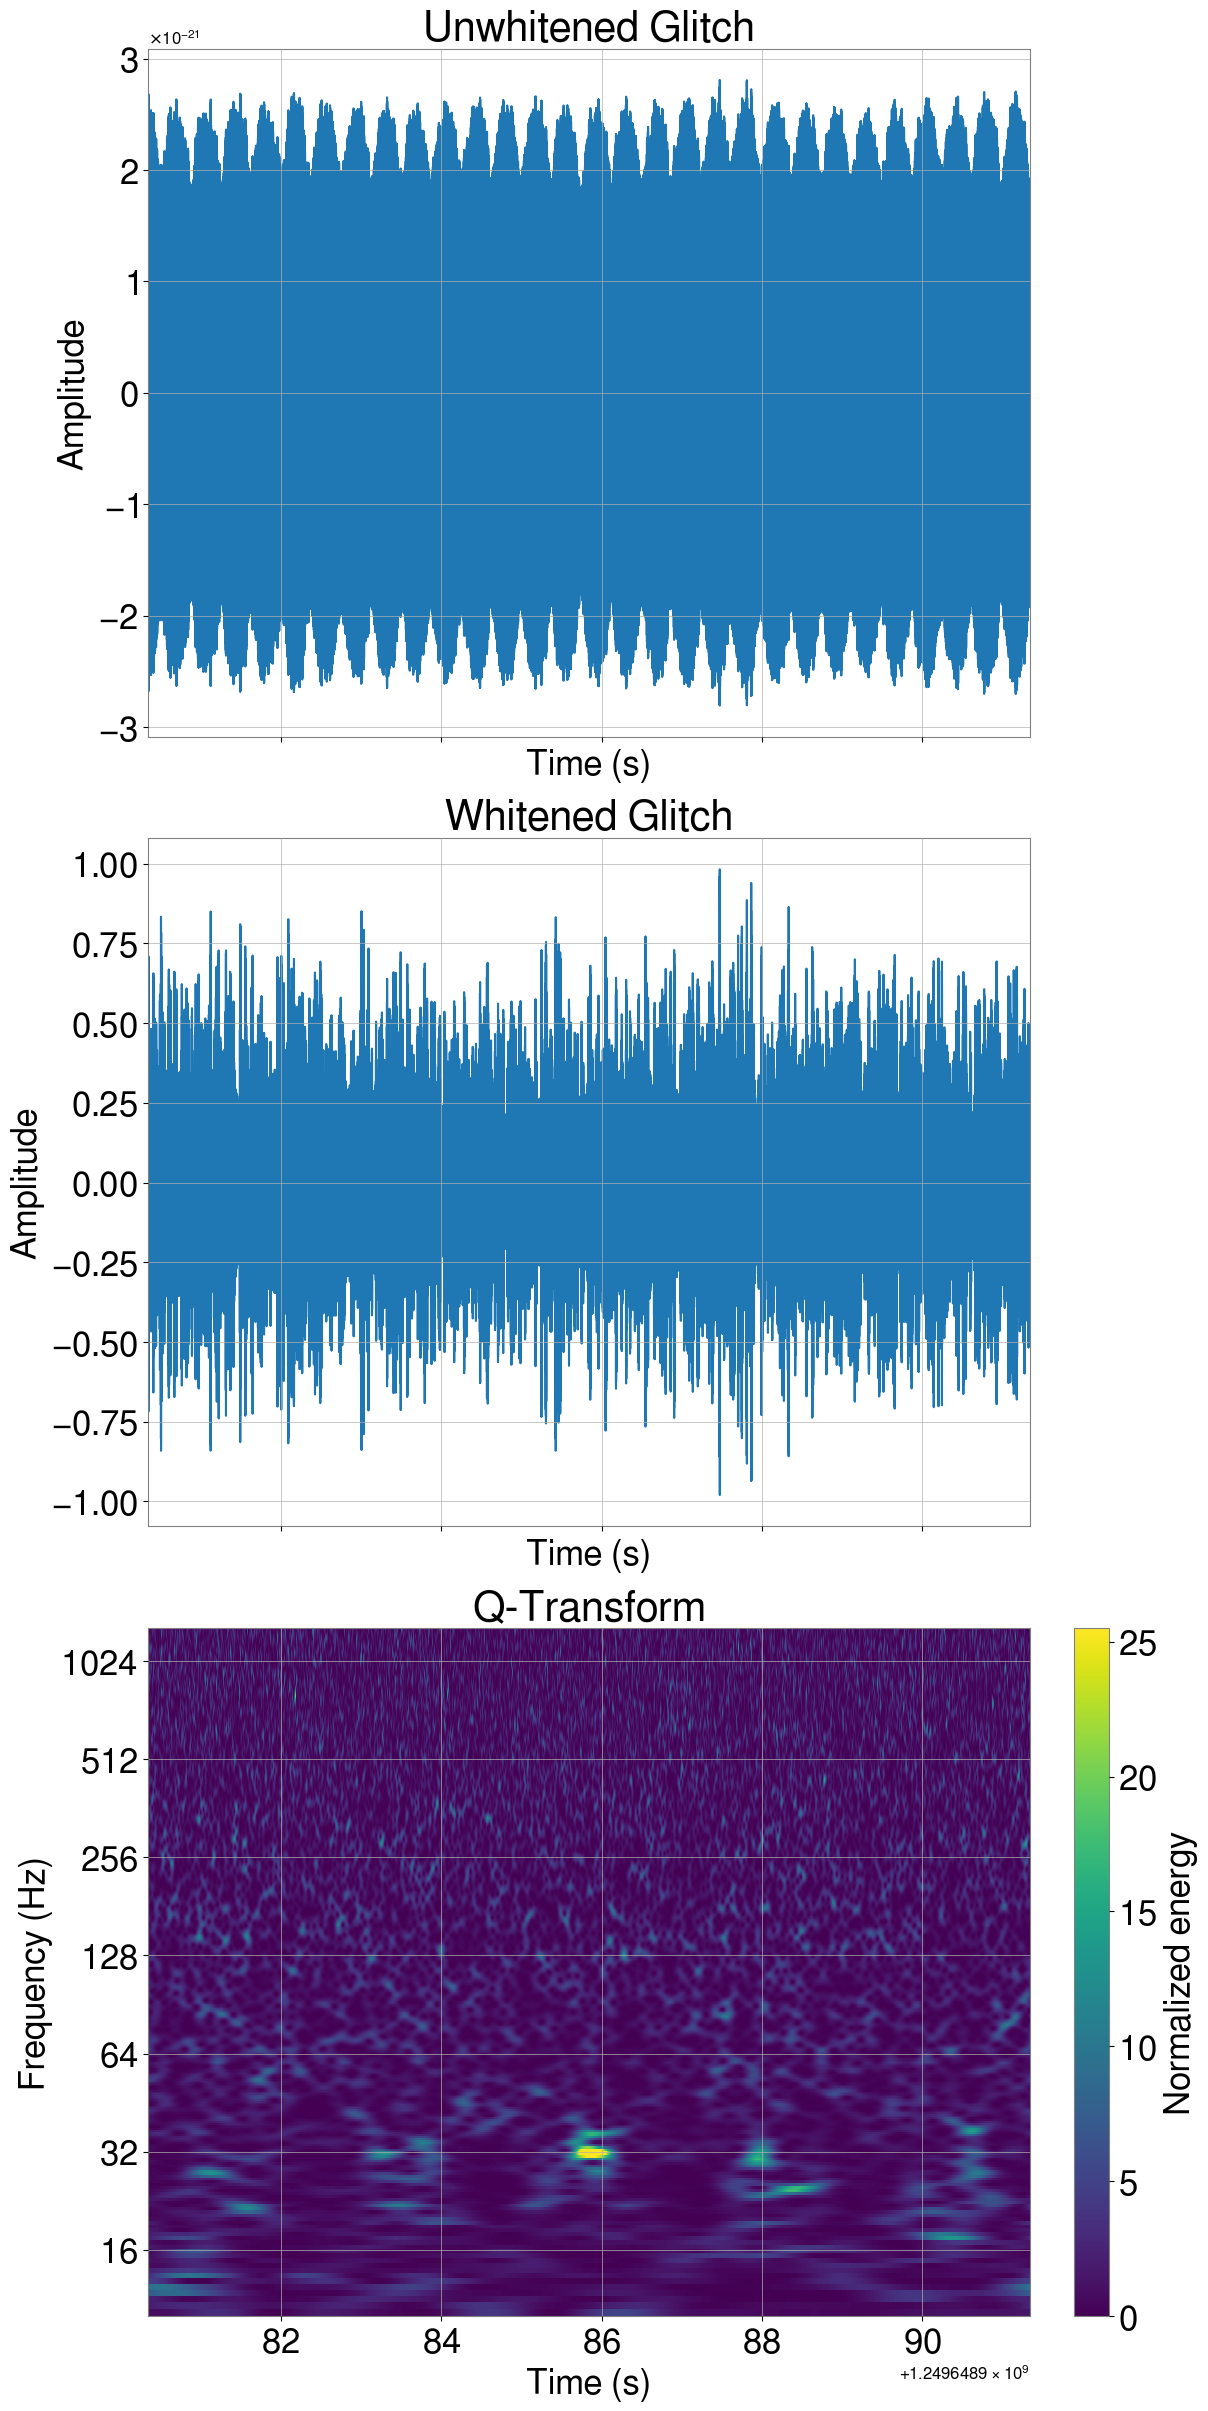

In [42]:
statistical_testing.display_sample_plots(combined_df[combined_df['label'] == 'Scattered_Light'].sample(1).iloc[0])

# Experimenting with the Fractal Dimension

The fractal dimension is another way for us to visualize and characterize our data. FD characterizes the self similarity of a set and provides a measure of complexity of the signal in terms of signal processing. Basically, it tells us how complex a shape is, which in this case would be the shape of the time series signal. If we were to use this in the context of time series signals, it would be as a **Variation over Time** telling us how complex the signal is. Glitches cause this FD value to change.

For this we use the VAR method. (Referenced from LIGO repositories)

In [20]:
combined_df.shape

(3597, 16)

In [21]:
# Tomte
example = combined_df.loc[combined_df['label'] == 'Tomte'].iloc[0]
example_ts = statistical_testing.get_sample_glitch_from_filepath(example["timeseries_file_location"])[1]

In [22]:
# Clean Signal
example2 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[1]

example_ts2 = TimeSeries.read(example2["timeseries_file_location"])
example_ts2 = example_ts2.whiten(4,2)
example_ts2 = example_ts2[int(4096):int(20480)]

asd = example_ts2.asd()

In [23]:
# Scattered Light
example3 = combined_df.loc[combined_df['label'] == 'Scattered_Light'].iloc[0]
example_ts3 = statistical_testing.get_sample_glitch_from_filepath(example3["timeseries_file_location"])[1]

In [24]:
example["timeseries_file_location"]

'./timeseries_data/sample_L1_1246837203.771_10.h5'

In [25]:
example_ts.shape

(4096,)

In [26]:
np.arange(0, 4096//(2*64))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31])

In [27]:
import numba

### What's happening here (My understanding of it)

F_k contains all the fractional dimensions being calculated for the given TimeSeries signal given the decimate value.

To calculate F_k, the outer loop takes values from 1 to half the length of the signal times the deimate, while the inner loop goes from the value of the outer loop to the end of the signal minus the outer loop value. At each iteration of the inner loop a window  of size [k-l, k-l+1] goes along the signal and calculates the absolute value of the difference between the minimum and maximum amplitude values, the mean of which us the A_var values. With each outer iteration the size of this window increases gradually until it goes up to the whole length of the signal.

In [28]:
# @numba.njit(parallel=True)
# def compute_fractals_var(arr, decimate=64, step=2):
#     # Fractal dimensions array for each segment
#     # fds = np.empty(shape=arr.shape[0], dtype=np.float32)
#     N = arr.shape[0]

#     F_k = [
#         [np.abs(np.max(arr[l-k:l+k+1]) - np.min(arr[l-k:l+k+1])) for l in np.arange(k, N-k)] \
#             for k in np.arange(1, N//(2*decimate), step)
#         ]
#     A_var = [np.mean(np.asarray(F_k[k])) for k in np.arange(len(F_k))]
#     epsilon = [(2*k)+1 for k in np.arange(1, N//(2*decimate), step)]
#     return (np.array(A_var), F_k, epsilon)


In [29]:
# fd = compute_fractals_var(example_ts)


In [30]:
# len(fd[1][15])

In [31]:
# Tomte
# median = np.median(fd[1][10])
# std = np.std(fd[1][10])
# plt.plot(fd[1][10], 'o')
# plt.axhline(median, color='red', linestyle='--', label='Mean')
# plt.axhline(median + (2*std), color='grey', linestyle='--', label='Mean + Std')
# plt.axhline(median - (2*std), color='grey', linestyle='--', label='Mean - Std')


In [32]:
# plt.plot(fd[0], 'o')

In [33]:
# mb_D = np.log(fd[0]) / np.log(fd[2])
# plt.plot(mb_D, 'o')

In [34]:
# plt.loglog(asd)

In [35]:
# example_ts2.plot()

In [36]:
# fd2 = compute_fractals_var(example_ts2)

In [37]:
# Clean Signal
# plt.plot(fd2[1][15], 'o')

In [38]:
# plt.plot(fd2[0], 'o')

In [39]:
# mb_D = np.log(fd2[0]) / np.log(fd2[2])
# plt.plot(mb_D, 'o')

In [40]:
# fd3 = compute_fractals_var(example_ts3)

In [41]:
#Scattered Light
# plt.plot(fd3[1][15], 'o')

In [42]:
# plt.plot(fd3[0], 'o')

In [43]:
# mb_D = np.log(fd3[0]) / np.log(fd3[2])
# plt.plot(mb_D, 'o')

Second version of FD code (the correct implementation) 

In [44]:
@numba.njit("f4[:](f4[:,:], i8, i8)", parallel=True)
def faster_compute_fractals_var(fs, dec, step):
    FDs = np.empty(shape=fs.shape[0], dtype=np.float32)
    N = fs.shape[1]
    for ii in numba.prange(fs.shape[0]):
        f = fs[ii]
        k_n = np.arange(1, N//(2*dec), step, np.int64)
        n_max = len(k_n)
        V_i = np.empty(shape=(n_max), dtype=np.float32)

        ub = np.empty(shape=(N-2*k_n[0],2), dtype=np.float32) # current iteration
        for i in range(0, N-2*k_n[0]):
            ub[i,0] = np.max(f[i:i+2*k_n[0]+1])
            ub[i,1] = np.min(f[i:i+2*k_n[0]+1])
        V_i[0] = np.mean(ub[:,0]-ub[:,1])

        for n in range(1,n_max):
            d = k_n[n] - k_n[n-1]
            for i in range(0, N-2*k_n[n]):
                ub[i,0] = max(ub[i,0], ub[i+2*d,0])
                ub[i,1] = min(ub[i,1], ub[i+2*d,1])
            V_i[n] = np.mean(ub[:N-2*k_n[n],0]-ub[:N-2*k_n[n],1])

        X = np.log(k_n)
        X_m = X - np.mean(X)
        Y = np.log(V_i)
        Y_m = Y - np.mean(Y)
        FDs[ii] = 2 - np.sum((X_m)*(Y_m))/np.sum((X_m)**2)
    return FDs


In [45]:
def segmentize(data, seg_length, overlap):
    """
    Segment the data into overlapping segments.
    """

    data_strides = data.strides

    num_segs = int((data.shape[1] - overlap)/(seg_length - overlap))
    seg_shape = (data.shape[0], num_segs, seg_length)

    seg_strides = (data_strides[0], data_strides[1]*(seg_length - overlap), data_strides[1])

    segs = np.lib.stride_tricks.as_strided(data, shape=seg_shape, strides=seg_strides)

    return segs
    

In [46]:
# eg_ts2d_chunks = np.split(example_ts.value, 64)

In [47]:
# len(eg_ts2d_chunks)

In [48]:
# eg_fd1 = []
# for chunk in eg_ts2d_chunks:
#     eg_fd1.append(faster_compute_fractals_var(np.array(chunk.reshape(1,-1).astype(np.float32)), dec=8, step=2))

In [74]:
eg_ts2d = example_ts.value.reshape(1,-1).astype(np.float32)

In [75]:
eg_ts2d.shape

(1, 4096)

In [76]:
eg_ts2d_segmented = segmentize(eg_ts2d, 64, 32)

In [86]:
eg_ts2d_segmented.shape

(1, 127, 64)

In [91]:
points_per_seg = eg_ts2d_segmented.shape[1]
eg_ts2d_segmented = eg_ts2d_segmented.reshape(eg_ts2d_segmented.shape[0]*eg_ts2d_segmented.shape[1], eg_ts2d_segmented.shape[2])

In [99]:
eg_ts2d_segmented.shape

(127, 64)

In [106]:
eg_fd1 = faster_compute_fractals_var(eg_ts2d_segmented, dec=2, step=2)

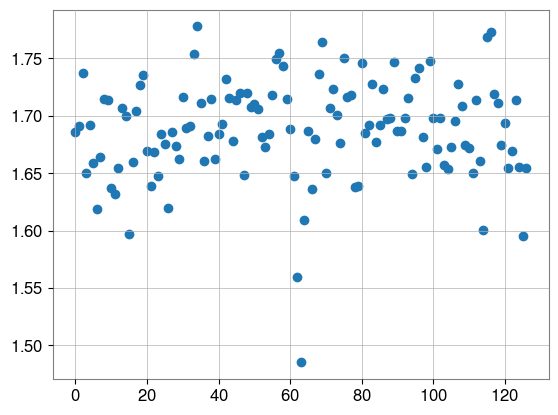

In [107]:
# Tomte
plt.plot(eg_fd1, 'o')

In [ ]:
eg_ts2d2 = example_ts2.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented2 = segmentize(eg_ts2d2, 64, 32)
points_per_seg = eg_ts2d_segmented2.shape[1]
eg_ts2d_segmented2 = eg_ts2d_segmented2.reshape(eg_ts2d_segmented2.shape[0]*eg_ts2d_segmented2.shape[1], eg_ts2d_segmented2.shape[2])
eg_fd2 = faster_compute_fractals_var(eg_ts2d_segmented2, dec=2, step=2)

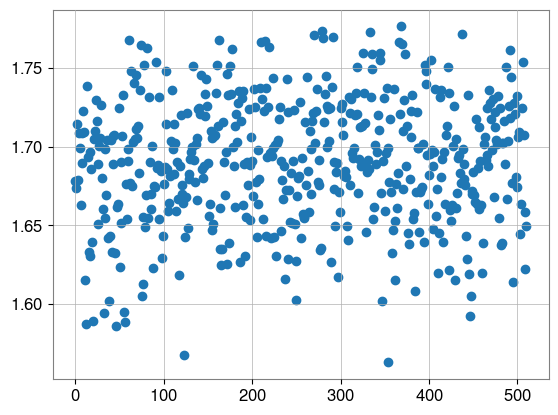

In [112]:
#Clean Signal
plt.plot(eg_fd2, 'o')

In [39]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)

In [113]:
eg_ts2d3 = example_ts3.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented3 = segmentize(eg_ts2d3, 64, 32)
points_per_seg = eg_ts2d_segmented3.shape[1]
eg_ts2d_segmented3 = eg_ts2d_segmented3.reshape(eg_ts2d_segmented3.shape[0]*eg_ts2d_segmented3.shape[1], eg_ts2d_segmented3.shape[2])
eg_fd3 = faster_compute_fractals_var(eg_ts2d_segmented3, dec=2, step=2)

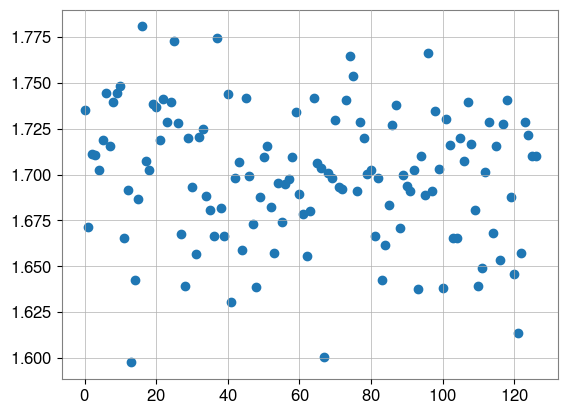

In [114]:
#Scattered Light
plt.plot(eg_fd3, 'o')

In [116]:
example4 = combined_df.loc[combined_df['label'] == 'Extremely_Loud'].iloc[1]
example_ts4 = statistical_testing.get_sample_glitch_from_filepath(example4["timeseries_file_location"])[1]

In [117]:
eg_ts2d4 = example_ts4.value.reshape(1,-1).astype(np.float32)
eg_ts2d_segmented4 = segmentize(eg_ts2d4, 64, 32)
points_per_seg = eg_ts2d_segmented4.shape[1]
eg_ts2d_segmented4 = eg_ts2d_segmented4.reshape(eg_ts2d_segmented4.shape[0]*eg_ts2d_segmented4.shape[1], eg_ts2d_segmented4.shape[2])
eg_fd4 = faster_compute_fractals_var(eg_ts2d_segmented4, dec=2, step=2)

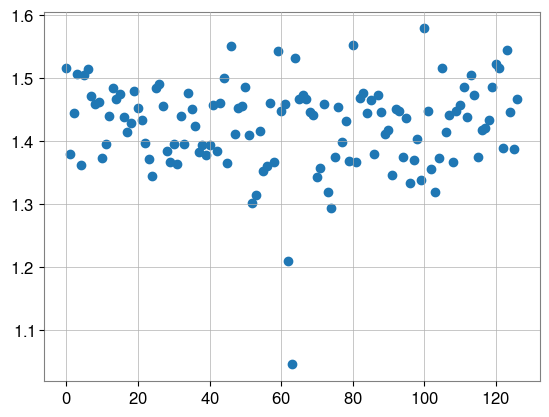

In [118]:
# Extremely Loud
plt.plot(eg_fd4, 'o')

In [46]:
# Second Scattered Light example
example5 = combined_df.loc[combined_df['label'] == 'clean_signal'].iloc[3]

example_ts5 = TimeSeries.read(example5["timeseries_file_location"])
example_ts5 = example_ts2.whiten(4,2)
example_ts5 = example_ts2[int(12288):int(16384)]

In [47]:
eg_ts2d5 = example_ts5.value.reshape(1,-1).astype(np.float32)

In [48]:
eg_fd5 = faster_compute_fractals_var(eg_ts2d5, dec=64, step=2)

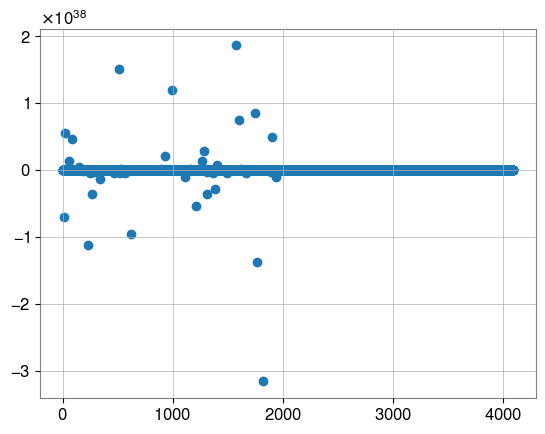

In [49]:
plt.plot(eg_fd5, 'o')

### Studying the FFTs of the signals

In [ ]:
from scipy import signal

eg_fft = example_ts.fft()
eg_fft2 = example_ts2.fft()
eg_fft3 = example_ts3.fft()

f1, t1, Zxx1 = signal.stft(example_ts, fs=4096, nperseg=32, noverlap=16)
f2, t2, Zxx2 = signal.stft(example_ts2, fs=4096, nperseg=32, noverlap=16)
f3, t3, Zxx3 = signal.stft(example_ts3, fs=4096, nperseg=32, noverlap=16)

In [ ]:
# Tomte
plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

In [ ]:
# Clean Signal
plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

In [ ]:
# Scattered Light
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.ylabel('Hz')
plt.xlabel('Sec')
plt.colorbar(label='Amplitude')
plt.show()

In [ ]:
# Tomte
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [ ]:
# Clean Data
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="FFT")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [ ]:
# Scattered Light
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(eg_fft.frequencies, np.abs(eg_fft.value), label="Tomte FFT", alpha=0.5)
plt.plot(eg_fft2.frequencies, np.abs(eg_fft2.value), label="Clean Data FFT", alpha=0.5)
plt.plot(eg_fft3.frequencies, np.abs(eg_fft3.value), label="Scattered Light FFT", alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6), dpi=150)
plt.hist(np.abs(eg_fft.value), label="Tomte FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft2.value), label="Clean Data FFT", bins=50, density=True, alpha=0.5)
plt.hist(np.abs(eg_fft3.value), label="Scattered Light FFT", bins=50, density=True, alpha=0.5)
plt.yscale('log')
plt.xlim(0,0.5)
plt.ylabel("Count")
plt.title("FFT of Example Signal")
plt.legend()
plt.show()

In [ ]:
example

In [ ]:
example2

In [ ]:
example3

In [ ]:
eg_q_transform, eg_time = statistical_testing.calculate_q_transform(example_ts)
eg_q_transform2, eg_time2 = statistical_testing.calculate_q_transform(example_ts2)
eg_q_transform3, eg_time3 = statistical_testing.calculate_q_transform(example_ts3)

print(eg_time,eg_time2,eg_time3)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform2)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(eg_q_transform3)
ax.set_yscale('log', base=2)
ax.set_xscale('linear')
ax.set_ylabel('Frequency (Hz)', fontsize=25)
ax.set_xlabel('Time (s)', fontsize=25)
ax.images[0].set_clim(0, 25.5)
ax.set_title("Q-Transform", fontsize=30)
ax.tick_params(axis='both', which="major", labelsize=25)
ax.tick_params(axis='both', which="minor", labelsize=25)
cbr = fig.colorbar(ax.images[0], ax=ax, label='Normalized energy', orientation='vertical', fraction=0.046, pad=0.05)
#set colorbar fontsize
cbr.set_label('Normalized energy', fontsize=25)
cbr.ax.tick_params(labelsize=25)

# Plots for the report

1. Gaussian Distribution

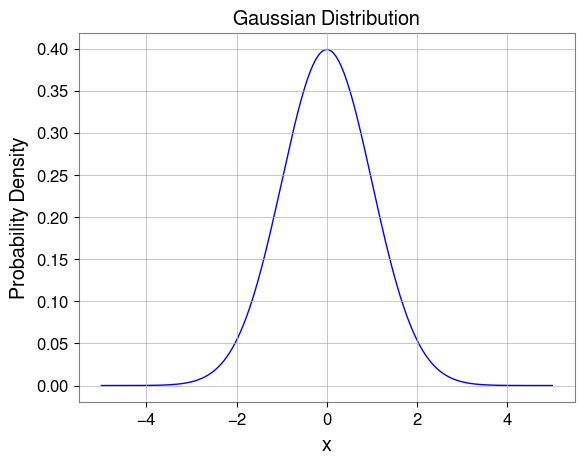

In [13]:
x = np.linspace(-5, 5, 1000)

mean = 0
stddev = 1

pdf = stats.norm.pdf(x, mean, stddev)

plt.plot(x, pdf, color='blue', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution')
plt.grid(True)
plt.savefig("./outputs/gaussian_distribution.pdf", dpi=100)

2. Speed comparison of generating Q-transforms for different TimeSeries lengths

In [3]:
from gwosc.datasets import event_gps

gw150914_gpstime = event_gps('GW150914')

window_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20]

q_transform_times = []

# Loading TimeSeries data for GW150914

for window_size in window_sizes:
    gw_ts = TimeSeries.fetch_open_data('L1', gw150914_gpstime - window_size, gw150914_gpstime + window_size)
    gw_ts = gw_ts[int(4096):-int(4096)]
    gw_ts = gw_ts.whiten(4, 2)
    _, time = statistical_testing.calculate_q_transform(gw_ts)
    q_transform_times.append(time)

In [4]:
q_transform_times

[0.2899458408355713,
 0.3819589614868164,
 0.4904332160949707,
 0.5846781730651855,
 0.6873571872711182,
 0.7996704578399658,
 0.8930633068084717,
 1.0094125270843506,
 1.1217939853668213]

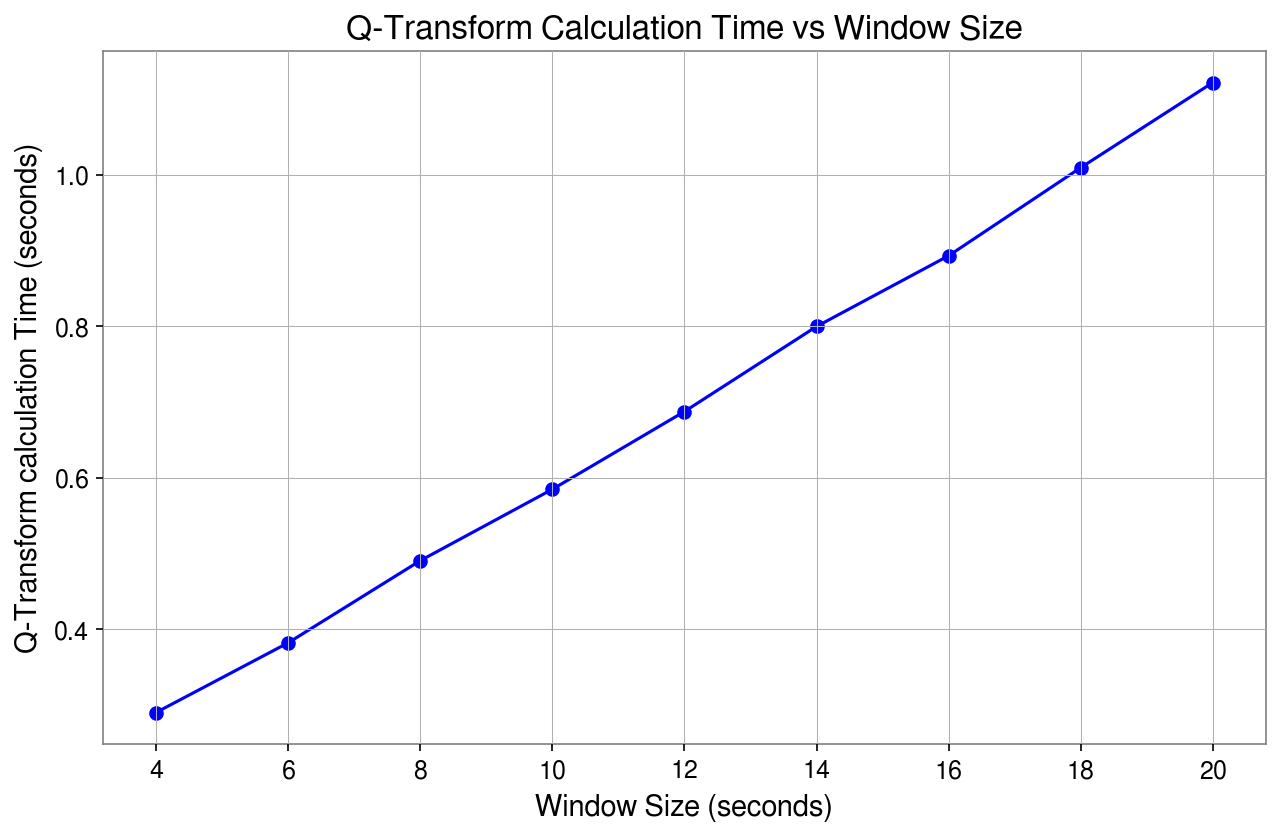

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(window_sizes, q_transform_times, marker='o', linestyle='-', color='blue')
ax.set_xlabel('Window Size (seconds)', fontsize=14)
ax.set_ylabel('Q-Transform calculation Time (seconds)', fontsize=14)
ax.set_title('Q-Transform Calculation Time vs Window Size', fontsize=16)
ax.grid(True)
plt.xticks(window_sizes)
plt.show()